In [3]:
from myenv.models.candlestick import Candlestick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


candlestick = Candlestick()

bitcoin_prices = candlestick.to_df()

bitcoin_prices.describe()


total = bitcoin_prices.date.count()


# GIAO DỊCH TRONG BIÊN ĐỘ


<Figure size 432x288 with 0 Axes>

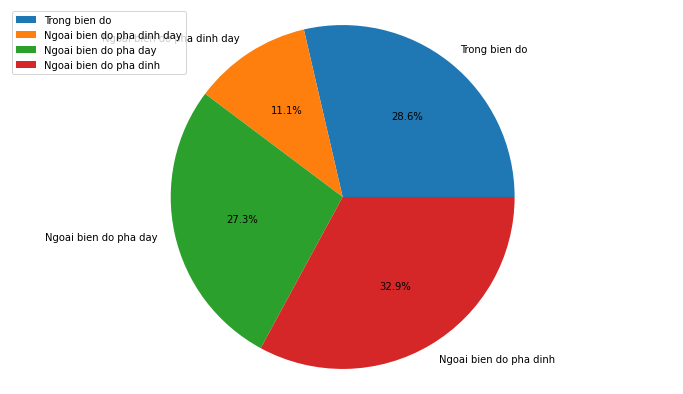

Đối với tập dự liệu giá BTC từ 2017-08-17 đến 2021-07-17, xác suất của việc mức giá cao nhất bị phá vỡ là 44.0%, mức giá thấp nhất bị phá vỡ là 38.5% và cả hai đỉnh đáy bị phá vỡ là 11.1%.
Có ít hơn 28.6% số ngày là những ngày giao dịch trong biên độ


In [11]:
data = [0]

for index, row in bitcoin_prices.iterrows():
    if index < 1 or index > bitcoin_prices['close'].count() - 1:
        continue
    
    # trong biên độ
    inside_bar_type = 0

    if row['low'] < bitcoin_prices.iloc[index - 1]['low'] and row['high'] > bitcoin_prices.iloc[index - 1]['high']:
        # Ngoài biên độ phá vỡ đỉnh và dáy
        inside_bar_type = 1
    elif row['low'] < bitcoin_prices.iloc[index - 1]['low']:
        # Ngoài biên độ phá vỡ dáy
        inside_bar_type = 2
    elif row['high'] > bitcoin_prices.iloc[index - 1]['high']:
        # Ngoài biên độ phá vỡ đỉnh
        inside_bar_type = 3

    data.append(inside_bar_type)

bitcoin_prices['inside_bar_type'] = data

group_inside_bar_type = bitcoin_prices.groupby(
    'inside_bar_type').inside_bar_type.count()

labels = 'Trong bien do', 'Ngoai bien do pha dinh day', 'Ngoai bien do pha day', 'Ngoai bien do pha dinh'
sizes = [group_inside_bar_type.loc[0],
         group_inside_bar_type.loc[1], group_inside_bar_type.loc[2], group_inside_bar_type.loc[3]]

plt.figure()
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend()
plt.show()

first_date = bitcoin_prices.loc[0, 'date'].date()
last_date = bitcoin_prices.iloc[-1, 0].date()
probability_break_high = '{:.1%}'.format((group_inside_bar_type.loc[3] +
                                          group_inside_bar_type.loc[1])/total)
probability_break_low = '{:.1%}'.format((group_inside_bar_type.loc[2] +
                                         group_inside_bar_type.loc[1])/total)
probability_break_both = '{:.1%}'.format(group_inside_bar_type.loc[1]/total)
probability_inside_day = '{:.1%}'.format(group_inside_bar_type.loc[0]/total)

print(
    f"Đối với tập dự liệu giá BTC từ {first_date} đến {last_date}, xác suất của việc mức giá cao nhất bị phá vỡ là {probability_break_high}, mức giá thấp nhất bị phá vỡ là {probability_break_low} và cả hai đỉnh đáy bị phá vỡ là {probability_break_both}.")
print(
    f"Có ít hơn {probability_inside_day} số ngày là những ngày giao dịch trong biên độ")


# HIỆU ỨNG NGÀY TRONG TUẦN VÀ HÀNH VI THỊ TRƯỜNG

In [4]:
candlestick_week = Candlestick(interval="week")

bitcoin_prices_week = candlestick_week.to_df()

bitcoin_prices_week.describe()

bitcoin_prices_week['day_name'] = bitcoin_prices_week[['date']].apply(
    lambda x: x['date'].strftime("%A"), axis=1)

print(bitcoin_prices_week)


          date      open      high     close       low day_name
0   2017-08-21   4069.13   4453.91   4310.01   3400.00   Monday
1   2017-08-28   4310.01   4939.19   4509.08   4124.54   Monday
2   2017-09-04   4505.00   4788.59   4130.37   3603.00   Monday
3   2017-09-11   4153.62   4394.59   3699.99   2817.00   Monday
4   2017-09-18   3690.00   4123.20   3660.02   3505.55   Monday
..         ...       ...       ...       ...       ...      ...
199 2021-06-14  39020.60  41330.00  35600.20  33336.00   Monday
200 2021-06-21  35600.20  35750.00  34700.30  28805.00   Monday
201 2021-06-28  34702.50  36600.00  35286.50  32699.00   Monday
202 2021-07-05  35288.10  35293.80  34259.00  32077.00   Monday
203 2021-07-12  34259.00  34678.40  31299.00  31020.00   Monday

[204 rows x 6 columns]


In [12]:
data = []

bitcoin_prices.loc[:, 'date']
bitcoin_prices['day_name'] = bitcoin_prices[['date']].apply(
    lambda x: x['date'].strftime("%A"), axis=1)

bitcoin_prices


,date,open,high,close,low,inside_bar_type,day_name
0,2017-08-17,4261.48,4485.39,4285.08,4200.74,0,Thursday
1,2017-08-18,4285.08,4371.52,4108.37,3938.77,2,Friday
2,2017-08-19,4108.37,4184.69,4139.98,3850.00,2,Saturday
3,2017-08-20,4120.98,4211.08,4086.29,4032.62,3,Sunday
4,2017-08-21,4069.13,4119.62,4016.00,3911.79,2,Monday
...,...,...,...,...,...,...,...
1630,2021-07-13,33086.90,33340.00,32729.80,32202.20,0,Tuesday
1631,2021-07-14,32729.10,33114.00,32820.00,31550.00,2,Wednesday
1632,2021-07-15,32820.00,33185.20,31880.00,31133.00,1,Thursday
1633,2021-07-16,31874.50,32249.20,31383.90,31020.00,2,Friday
